# "Microsoft Studios:"
### _How should Microsoft Enter the Movie Business?_
>##### __G. Haws & K. Hayes__
>###### July 31, 2019
***
>*Sources:\
TheMovieDB.org\
Box Office Mojo\
IMBD*

### Questions to Consider:

>### - In order to maximize its investment, what scale of films should Microsoft produce?
>### - What types of studios should Microsoft emulate?
>### - Which directors should Microsoft seek?

#### Step One: Import the Tools...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
from Microsoft_Clean import *

#### Step Two: Import the Data...

In [2]:
tn_budget = pd.read_csv('Data/Zipped_Data/tn.movie_budgets.csv.gz',\
                        compression='gzip')
bom_gross = pd.read_csv('Data/Zipped_Data/bom.movie_gross.csv.gz',\
                        compression='gzip')
imbd_basics = pd.read_csv('Data/Zipped_Data/imdb.title.basics.csv.gz',\
                          compression='gzip')
imbd_name = pd.read_csv('Data/Zipped_Data/imdb.name.basics.csv.gz',\
                        compression='gzip')
imbd_principals = pd.read_csv('Data/Zipped_Data/imdb.title.principals.csv.gz',\
                              compression='gzip')

#### Step Three: Clean the Data...
>_* N.B. - the below is an abstraction; the actual cleaing process is rather lengthy..._  
>                 _...this code takes in a list of dataframes and condenses them into one:_

In [3]:
md_clean = Clean_Data(tn_budget, bom_gross, imbd_basics, imbd_name, imbd_principals)

In [4]:
md_clean.head()

,title,production_budget,worldwide_gross,net,ratio,year,studio,genres,director,producer
0,avatar,425000000.0,2.776345e+09,2.351345e+09,5.532577,2009,Unknown,NaN,Unknown,Unknown
1,pirates of caribbean on stranger tides,410600000.0,1.045664e+09,6.350639e+08,1.546673,2011,BV,"Action,Adventure,Fantasy",Rob Marshall,Unknown
2,dark phoenix,350000000.0,1.497624e+08,-2.002376e+08,-0.572108,2019,Unknown,"Action,Adventure,Sci-Fi",Simon Kinberg,Unknown
3,avengers age of ultron,330600000.0,1.403014e+09,1.072414e+09,3.243842,2015,BV,"Action,Adventure,Sci-Fi",Joss Whedon,Kevin Feige
4,star wars ep viii last jedi,317000000.0,1.316722e+09,9.997218e+08,3.153697,2017,Unknown,NaN,Unknown,Unknown


#### Step Four: Data Visualizations (EDA)...

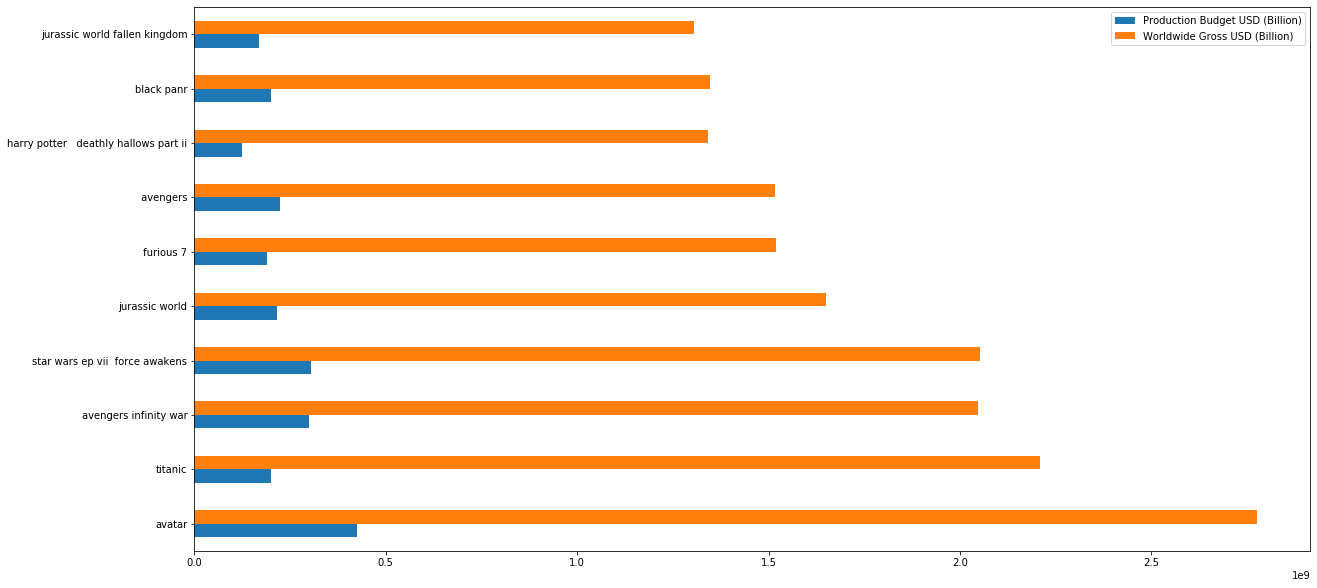

In [5]:
# Create earnings/cost graph for films with top ROI
top_net = md_clean.sort_values(by=['net'], ascending=False)[:10]

index = list(top_net['title'])
production_budget = list(top_net['production_budget'])
worldwide_gross = list(top_net['worldwide_gross'])
df = pd.DataFrame({'Production Budget USD (Billion)':
                   production_budget,
                   'Worldwide Gross USD (Billion)':
                   worldwide_gross}, index=index)
ax = df.plot.barh(figsize=(20, 10), rot=0)

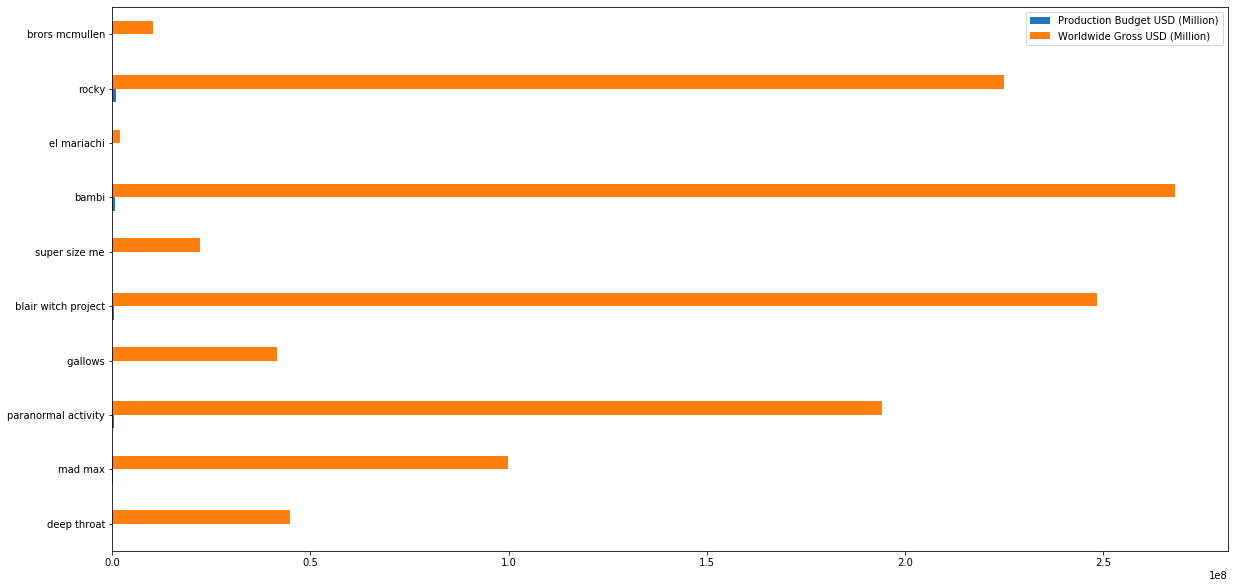

In [6]:
# Create earnings/cost graph for films with top ROI
top_ratio = md_clean.sort_values(by=['ratio'], ascending=False)[:10]

index = list(top_ratio['title'])
production_budget = list(top_ratio['production_budget'])
worldwide_gross = list(top_ratio['worldwide_gross'])
df = pd.DataFrame({'Production Budget USD (Million)': production_budget,
                   'Worldwide Gross USD (Million)': worldwide_gross},
                  index=index)
ax = df.plot.barh(figsize=(20, 10), rot=0)

In [7]:
# Create a list of 20 studios with the top ratio means
studio_ratio_mean = (md_clean.groupby
                     (['studio']).ratio.mean().
                     sort_values(ascending=False)[:20])

In [8]:
# Create a list of 20 directors with the top ratio means
director_ratio_mean = (md_clean.groupby
                       (['director']).ratio.mean().
                       sort_values(ascending=False)[0:20])

In [9]:
# Create a list of 19 directors with the top ROI means,
# with top value removed
director_ratio_mean_19 = (md_clean.groupby
                          (['director']).ratio.mean().
                          sort_values(ascending=False)[1:20])

In [10]:
# Create a list of 20 producers with the top ROI means
producer_ratio_mean = (md_clean.groupby
                       (['producer']).ratio.mean()
                       .sort_values(ascending=False)[:20])

In [11]:
# Provides a count for the number of films made by
# each director with a top-20 ROI
director_ROI_count = (md_clean.groupby
                      ('director')['ratio', 'title'].agg
                      ({'ratio': 'mean', 'title': 'nunique'})
                      .sort_values
                      (by='ratio', ascending=False))[0:20].reset_index()

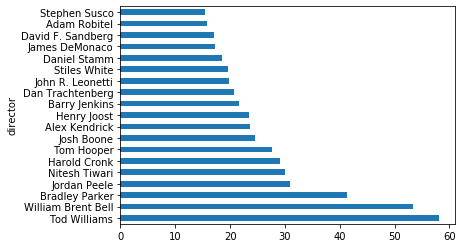

In [12]:
#Creates a graph of the 2-20 directors with the best ROI
director_ratio_mean_19.plot(kind='barh')

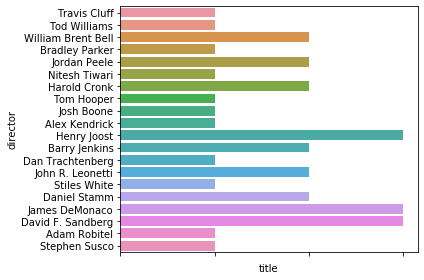

In [13]:
# Make a barplot - top 20 directors by ROI - Count
top_20_directors_ROI_count = (md_clean.groupby
                              ('director')['ratio', 'title']
                              .agg({'ratio':
                                    'mean', 'title': 'nunique'})
                              .sort_values
                              (by='ratio',
                               ascending=False))[0:20].reset_index()
ax = sns.barplot(x=top_20_directors_ROI_count['title'],
                 y=top_20_directors_ROI_count['director'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 1
plt.tight_layout()
plt.show()

### Recommendations:

>##### - Instead of focusing on overall returns, focus on ROI.
>##### - Model operations on studios capable of producing films that maximize ROI.
>##### - Hire directors that can creating engaging films, despite heavy budgetary constraints.
>##### - Hire new directors.